In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import string
import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black

In [4]:
# Load and Inspect Data
df = pd.read_csv("../data/The-Office-Lines-V4.csv")
print(df.columns)
print(df.info())
df.head()

Index(['season', 'episode', 'title', 'scene', 'speaker', 'line', 'Unnamed: 6'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54626 entries, 0 to 54625
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      54626 non-null  int64 
 1   episode     54626 non-null  int64 
 2   title       54626 non-null  object
 3   scene       54626 non-null  int64 
 4   speaker     54626 non-null  object
 5   line        54626 non-null  object
 6   Unnamed: 6  17 non-null     object
dtypes: int64(3), object(4)
memory usage: 2.9+ MB
None


,season,episode,title,scene,speaker,line,Unnamed: 6
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,NaN
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",NaN
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,NaN
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",NaN
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",NaN


In [5]:
# Select Columns
df = df[["season", "episode", "title", "scene", "speaker", "line"]]
df.head()

,season,episode,title,scene,speaker,line
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So..."
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah."
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done."


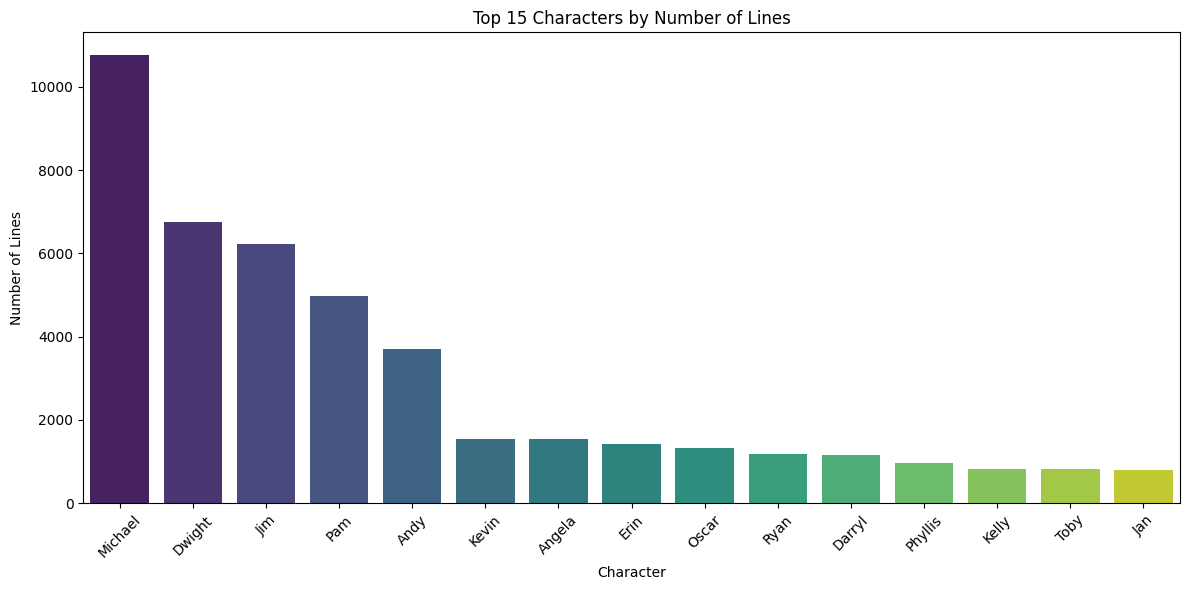

In [6]:
# Plot Top 15 Characters
speaker_counts = df["speaker"].value_counts().reset_index()
speaker_counts.columns = ["speaker", "line_count"]
plt.figure(figsize=(12, 6))
sns.barplot(
    data=speaker_counts.head(15), x="speaker", y="line_count", palette="viridis"
)
plt.xticks(rotation=45)
plt.title("Top 15 Characters by Number of Lines")
plt.xlabel("Character")
plt.ylabel("Number of Lines")
plt.tight_layout()
plt.show()

In [7]:
# Add Line Length and Word Count
df["line_length"] = df["line"].apply(len)
df["word_count"] = df["line"].apply(lambda x: len(str(x).split()))
df.head()

,season,episode,title,scene,speaker,line,line_length,word_count
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,78,14
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",42,9
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,83,14
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",42,8
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",47,10


Initial Speaker Cleaning

In [8]:
print("Number of unique speakers:", df["speaker"].nunique())

Number of unique speakers: 775


In [9]:
df["speaker"] = df["speaker"].str.strip().str.title()
print("Number of unique speakers:", df["speaker"].nunique())

Number of unique speakers: 753


In [10]:
print("Number of unique speakers:", df["speaker"].nunique())
# print(df["speaker"].unique())

Number of unique speakers: 753


In [11]:
corrections = {
    # Michael
    "Michael": "Michael",
    "Micheal": "Michael",
    "Micahel": "Michael",
    "Michae": "Michael",
    "Micael": "Michael",
    "Michal": "Michael",
    "Mihael": "Michael",
    "Miichael": "Michael",
    "M Ichael": "Michael",
    "Michael:": "Michael",
    "Michel": "Michael",
    # Dwight
    "Dwight": "Dwight",
    "Dwight:": "Dwight",
    "Dwight.": "Dwight",
    "Dwightkschrute": "Dwight",
    "D": "Dwight",
    # Jim
    '"Jim"': "Jim",
    "Jim:": "Jim",
    "Jim9334": "Jim",
    # Pam
    "Pam:": "Pam",
    # Andy
    "Andy:": "Andy",
    "Video Andy": "Andy",
    # Kevin
    "Kevin:": "Kevin",
    # Angela
    "Anglea": "Angela",
    "Angela:": "Angela",
    "Angels": "Angela",
    "Angel": "Angela",
    '"""Angela"""': "Angela",
    '"Angela"': "Angela",
    # Erin
    "Erin:": "Erin",
    # Oscar
    "Oscar:": "Oscar",
    "Oscar'S Voice From The Computer": "Oscar",
    # Ryan
    "Ryan'S Voicemail": "Ryan",
    "Ryan:": "Ryan",
    "Ryan And Others": "Ryan",
    "Ryan Howard": "Ryan",
    # Darryl
    "Darry": "Darryl",
    "Daryl": "Darryl",
    "Darryl:": "Darryl",
    "Darrly": "Darryl",
    # Phyllis
    "Phyllis": "Phyllis",
    "Phyllis:": "Phyllis",
    "Phyliss": "Phyllis",
    "Phylis": "Phyllis",
    '"""Phyllis"""': "Phyllis",
    # Kelly
    "Kelly:": "Kelly",
    # Stanley
    "Stanley:": "Stanley",
    "Stanely": "Stanley",
    # other characters
    "Everyone:": "Everyone",
    "Meredith:": "Meredith",
    "Creed:": "Creed",
    "Packer": "Todd Packer",
    "Jim, Josh, And Dwight": "Michael and Dwight",
    "Jim And Dwight": "Michael and Dwight",
    "Michael And Dwight": "Michael and Dwight",
    "Dwight And Michael": "Michael and Dwight",
    "Andy And Dwight": "Michael and Dwight",
    "Andy And Michael": "Michael and Dwight",
    "Dwight, Jim And Michael": "Michael and Dwight",
    "Jim, Pam, Michael And Dwight": "Michael and Dwight",
    "Ryan And Michael": "Michael and Dwight",
    "Kevin & Oscar": "Kevin and Oscar",
    "Pam/Jim": "Pam and Jim",
    "Billy'S Girlfriend": "Billy's Girlfriend",
    "Hooter'S Girls": "Hooter's Girls",
    "Chili'S Employee": "Chili's Employee",
    "Jim'S Voicemail": "Jim's Voicemail",
    "Ryan'S Voicemail": "Ryan's Voicemail",
    "All The Men": "All",
    "Kelly'S Mom": "Kelly's Mom",
    "Kelly'S Father": "Kelly's Father",
    "Michael'S Ad": "Michael's Ad",
    "Hunter'S Cd": "Hunter's Cd",
    "Wendy'S Phone Operator": "Wendy's Phone Operator",
    "David Wallace'S Secretary": "David Wallace's Secretary",
    "Pam'S Dad": "Pam's Dad",
    "Matt:": "Matt",
    "Warehouse Guy:": "Warehouse Guy",
    "Darryl:": "Darryl",
    "Julie:": "Julie",
    "Isabel:": "Isabel",
    "Hide:": "Hide",
    "Bar Manager:": "Bar Manager",
    "Bouncer:": "Bouncer",
    "Girl At Table:": "Girl At Table",
    "Hayworth'S Waiter": "Hayworth's Waiter",
    "Jim'S Dad": "Jim's Dad",
    "Holly'S Mom": "Holly's Mom",
    "Holly'S Dad": "Holly's Dad",
    "Darryl'S Sister": "Darryl's Sister",
    "Erin'S Cell Phone": "Erin's Cell Phone",
    "Chelsea'S Mom": "Chelsea's Mom",
    "Oscar'S Friend": "Oscar's Friend",
    "Oscar'S Computer": "Oscar's Computer",
    "Kevin & Oscar": "Kevin and Oscar",
    "Phyllis, Meredith, Michael, Kevin": "Phyllis and Meredith and Michael and Kevin",
    "Pam/Jim": "Pam and Jim",
    "Jim, Josh, And Dwight": "Jim and Josh and And Dwight",
    "Michael & Dwight": "Michael and Dwight",
    "Andy & Michael": "Andy and Michael",
    "Dunmiff/Sys": "Dunmiff and Sys",
    "Andy, Creed, Kevin, Kelly, Darryl": "Andy and Creed and Kevin and Kelly and Darryl",
    "Andy, Creed, Kevin, Kelly": "Andy and Creed and Kevin and Kelly",
    "Michael/Dwight": "Michael and Dwight",
    "Receptionitis15": "Receptionitis",
    "Michael & Holly": "Michael and Holly",
    "Michael, Holly, And Darryl": "Michael and Holly and And Darryl",
    "Jim, Pam, Michael And Dwight": "Jim and Pam and Michael And Dwight",
    "Michael, Pam & Ryan": "Michael and Pam and Ryan",
    "Dwight & Andy": "Dwight and Andy",
    "Jim & Pam": "Jim and Pam",
    "Andy & Erin": "Andy and Erin",
    "Dwight, Jim And Michael": "Dwight and Jim And Michael",
    "Dwight & Nate": "Dwight and Nate",
    "Phyllis, Stanley, Dwight": "Phyllis and Stanley and Dwight",
    "Deangelo/Michael": "Deangelo and Michael",
    '"Jo"': "Jo",
    '"Phyllis"': "Phyllis",
    'Pam As "Fourth-Biggest Client"': "Pam As Fourth-Biggest Client",
    'Pam As "Ninth-Biggest Client"': "Pam As Ninth-Biggest Client",
    "Dwight, Erin, Jim & Kevin": "Dwight and Erin and Jim and Kevin",
    "Andy & Walter": "Andy and Walter",
    "Walter & Walter Jr": "Walter and Walter Jr",
    "Gabe/Kelly/Toby": "Gabe and Kelly and Toby",
    "Andy/Pam": "Andy and Pam",
    "Andy/Stanley": "Andy and Stanley",
    "Andy/Oscar": "Andy and Oscar",
    "Angela/Pam": "Angela and Pam",
    "Kevin & Meredith": "Kevin and Meredith",
    "Robert & Creed": "Robert and Creed",
    "Phyllis, Kevin & Stanley": "Phyllis and Kevin and Stanley",
    "Angela & Oscar": "Angela and Oscar",
    "Bob Vance, Vance Refrigeration": "Bob Vance and Vance Refrigeration",
    "Jim & Dwight": "Jim and Dwight",
    "(Pam'S Mom) Heleen": "Pam's Mom",
    "Pam'S Mom": "Pam's Mom",
}

In [12]:
df["speaker"] = df["speaker"].replace(corrections)
print("Number of unique speakers:", df["speaker"].nunique())

Number of unique speakers: 692


In [13]:
top_speakers = df["speaker"].value_counts().head(20)
print(top_speakers)

speaker
Michael     10876
Dwight       6794
Jim          6262
Pam          5005
Andy         3734
Angela       1555
Kevin        1542
Erin         1429
Oscar        1357
Darryl       1210
Ryan         1205
Phyllis       972
Kelly         826
Toby          814
Jan           805
Stanley       674
Meredith      557
Holly         555
Nellie        527
Gabe          426
Name: count, dtype: int64


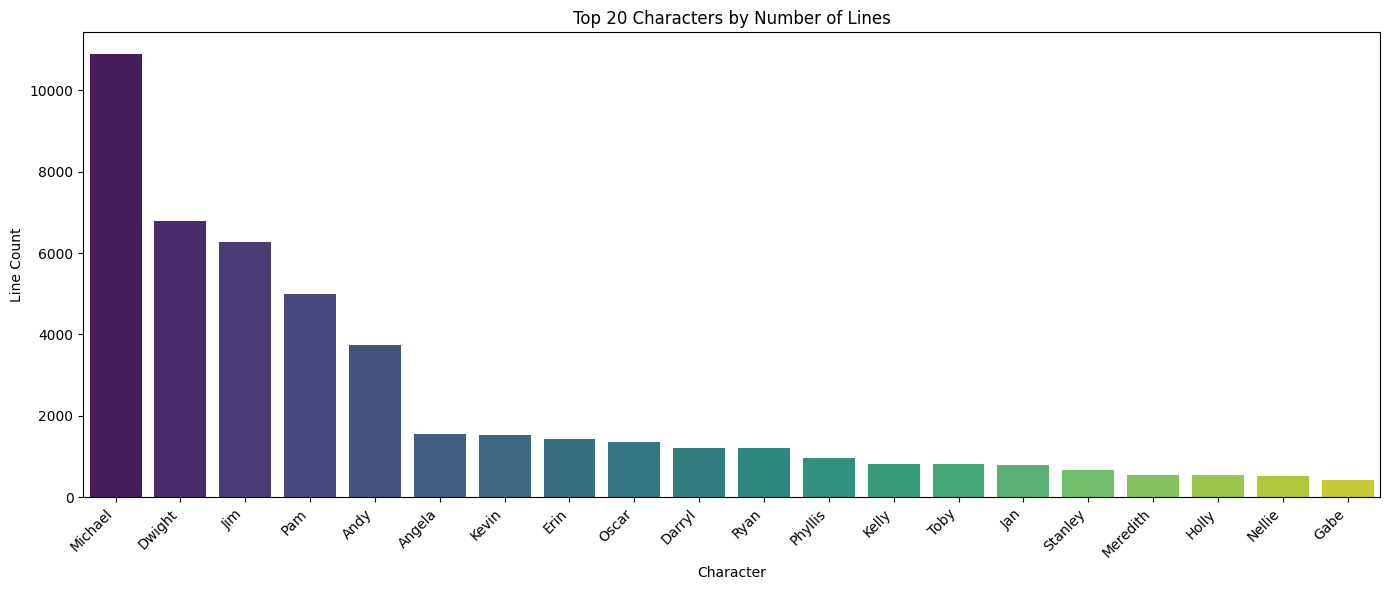

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.barplot(x=top_speakers.index, y=top_speakers.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Characters by Number of Lines")
plt.xlabel("Character")
plt.ylabel("Line Count")
plt.tight_layout()
plt.show()

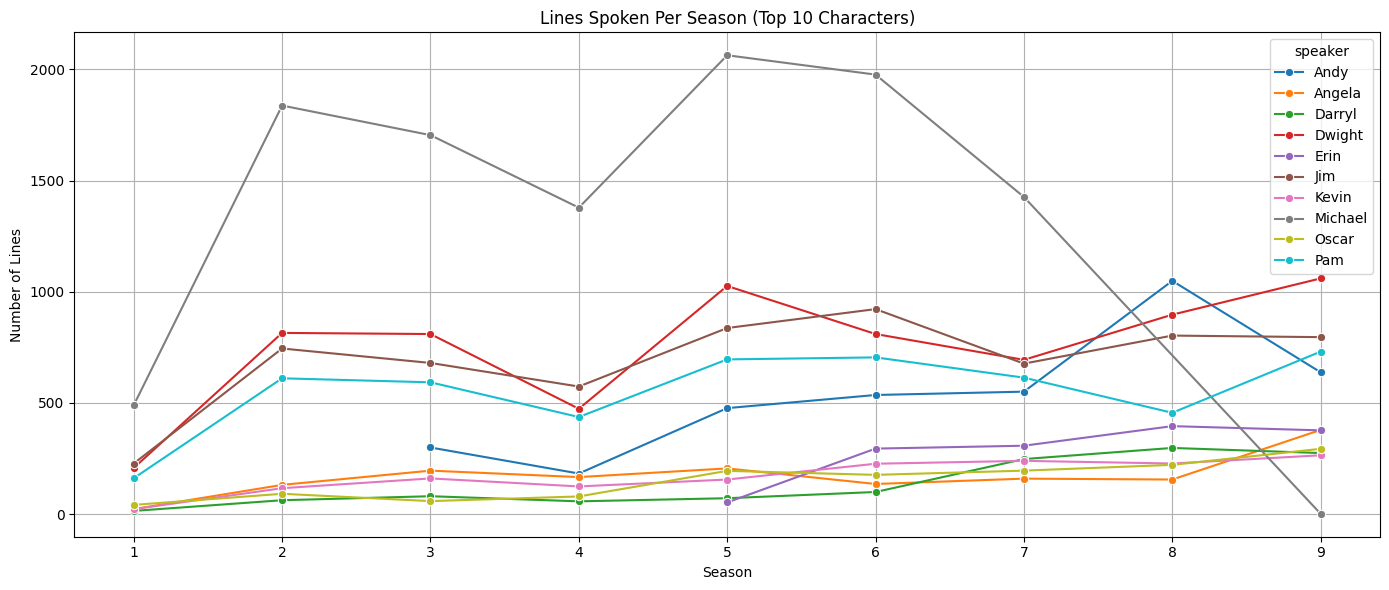

In [15]:
lines_by_speaker_season = (
    df.groupby(["speaker", "season"])["line"].count().reset_index()
)
lines_by_speaker_season = lines_by_speaker_season.sort_values(["speaker", "season"])

top_main = top_speakers.head(10).index
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=lines_by_speaker_season[lines_by_speaker_season["speaker"].isin(top_main)],
    x="season",
    y="line",
    hue="speaker",
    marker="o",
)
plt.title("Lines Spoken Per Season (Top 10 Characters)")
plt.xlabel("Season")
plt.ylabel("Number of Lines")
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
# pip install torch

Imports langauge model from huggingFace to clasify each line

In [ ]:
emotion_classifier = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=True,
)

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tf_model.h5:   0%|          | 0.00/329M [00:00<?, ?B/s]


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [18]:
def get_top_emotions(text, top_k=2):
    scores = emotion_classifier(text)[0]
    sorted_scores = sorted(scores, key=lambda x: x["score"], reverse=True)
    return [e["label"] for e in sorted_scores[:top_k]]

In [19]:
df["emotions"] = df["line"].apply(get_top_emotions)

In [20]:
df.head(10)

,season,episode,title,scene,speaker,line,line_length,word_count,emotions
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,78,14,"[neutral, joy]"
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",42,9,"[sadness, neutral]"
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,83,14,"[neutral, surprise]"
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",42,8,"[neutral, sadness]"
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",47,10,"[neutral, anger]"
5,1,1,Pilot,2,Michael,"Yes, I'd like to speak to your office manager...",443,81,"[neutral, sadness]"
6,1,1,Pilot,3,Michael,"I've, uh, I've been at Dunder Mifflin for 12 y...",308,59,"[neutral, surprise]"
7,1,1,Pilot,3,Pam,Well. I don't know.,19,4,"[surprise, neutral]"
8,1,1,Pilot,3,Michael,"If you think she's cute now, you should have s...",77,16,"[neutral, disgust]"
9,1,1,Pilot,3,Pam,What?,5,1,"[surprise, anger]"


In [ ]:
# Saving the DataFrame with emotions to a new CSV file
df.to_csv("../data/The-Office-With-Emotions.csv", index=False)

In [4]:
df = pd.read_csv("../data/The-Office-With-Emotions.csv")
df.head(10)

,season,episode,title,scene,speaker,line,line_length,word_count,emotions
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,78,14,"['neutral', 'joy']"
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",42,9,"['sadness', 'neutral']"
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,83,14,"['neutral', 'surprise']"
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",42,8,"['neutral', 'sadness']"
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",47,10,"['neutral', 'anger']"
5,1,1,Pilot,2,Michael,"Yes, I'd like to speak to your office manager...",443,81,"['neutral', 'sadness']"
6,1,1,Pilot,3,Michael,"I've, uh, I've been at Dunder Mifflin for 12 y...",308,59,"['neutral', 'surprise']"
7,1,1,Pilot,3,Pam,Well. I don't know.,19,4,"['surprise', 'neutral']"
8,1,1,Pilot,3,Michael,"If you think she's cute now, you should have s...",77,16,"['neutral', 'disgust']"
9,1,1,Pilot,3,Pam,What?,5,1,"['surprise', 'anger']"


Imports sarcasm detection module.

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import string

# Load the sarcasm model
MODEL_PATH = "helinivan/english-sarcasm-detector"
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)


def preprocess_data(text: str) -> str:
    return text.lower().translate(str.maketrans("", "", string.punctuation)).strip()


def detect_sarcasm(text, threshold=0.5):
    tokenized_text = tokenizer(
        [preprocess_data(text)],
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors="pt",
    )
    with torch.no_grad():
        output = model(**tokenized_text)
    probs = output.logits.softmax(dim=-1).tolist()[0]
    confidence = max(probs)
    prediction = probs.index(confidence)
    is_sarcastic = bool(prediction)  # Usually 1 = sarcastic, 0 = not
    return "sarcastic" if is_sarcastic and confidence >= threshold else "not_sarcastic"

In [6]:
df["sarcasm"] = df["line"].apply(detect_sarcasm)

In [7]:
df.head(20)

,season,episode,title,scene,speaker,line,line_length,word_count,emotions,sarcasm
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,78,14,"['neutral', 'joy']",not_sarcastic
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",42,9,"['sadness', 'neutral']",not_sarcastic
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,83,14,"['neutral', 'surprise']",not_sarcastic
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",42,8,"['neutral', 'sadness']",sarcastic
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",47,10,"['neutral', 'anger']",not_sarcastic
5,1,1,Pilot,2,Michael,"Yes, I'd like to speak to your office manager...",443,81,"['neutral', 'sadness']",sarcastic
6,1,1,Pilot,3,Michael,"I've, uh, I've been at Dunder Mifflin for 12 y...",308,59,"['neutral', 'surprise']",not_sarcastic
7,1,1,Pilot,3,Pam,Well. I don't know.,19,4,"['surprise', 'neutral']",not_sarcastic
8,1,1,Pilot,3,Michael,"If you think she's cute now, you should have s...",77,16,"['neutral', 'disgust']",not_sarcastic
9,1,1,Pilot,3,Pam,What?,5,1,"['surprise', 'anger']",not_sarcastic


Text(0.5, 1.0, 'Sarcasm Detection Results')

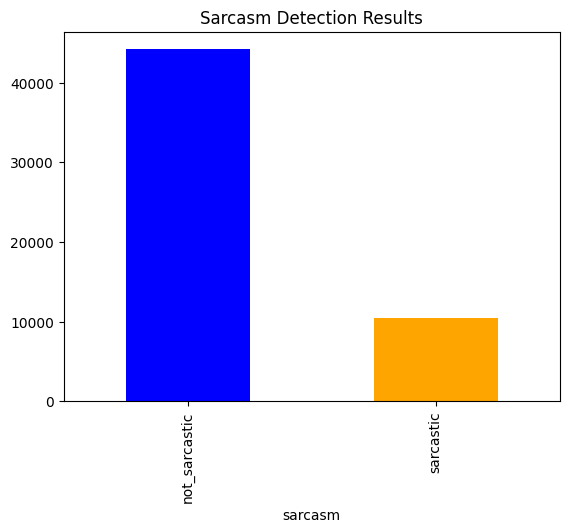

In [9]:
df.sarcasm.value_counts().plot(kind="bar", color=["blue", "orange"])
plt.title("Sarcasm Detection Results")

In [8]:
# Saving the DataFrame with emotions to a new CSV file
df.to_csv("../data/The-Office-With-Emotions-and-sarcasm.csv", index=False)

In [10]:
df = pd.read_csv("../data/The-Office-With-Emotions-and-sarcasm.csv")
df.head(10)

,season,episode,title,scene,speaker,line,line_length,word_count,emotions,sarcasm
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,78,14,"['neutral', 'joy']",not_sarcastic
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",42,9,"['sadness', 'neutral']",not_sarcastic
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,83,14,"['neutral', 'surprise']",not_sarcastic
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",42,8,"['neutral', 'sadness']",sarcastic
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",47,10,"['neutral', 'anger']",not_sarcastic
5,1,1,Pilot,2,Michael,"Yes, I'd like to speak to your office manager...",443,81,"['neutral', 'sadness']",sarcastic
6,1,1,Pilot,3,Michael,"I've, uh, I've been at Dunder Mifflin for 12 y...",308,59,"['neutral', 'surprise']",not_sarcastic
7,1,1,Pilot,3,Pam,Well. I don't know.,19,4,"['surprise', 'neutral']",not_sarcastic
8,1,1,Pilot,3,Michael,"If you think she's cute now, you should have s...",77,16,"['neutral', 'disgust']",not_sarcastic
9,1,1,Pilot,3,Pam,What?,5,1,"['surprise', 'anger']",not_sarcastic


In [ ]:
# Secondary Emotion Classifier
emotion_2_classifier = pipeline(
    "text-classification",
    model="bhadresh-savani/bert-base-uncased-emotion",
    return_all_scores=True,
)


def get_top_emotions(text, top_k=2):
    scores = emotion_2_classifier(text)[0]
    sorted_scores = sorted(scores, key=lambda x: x["score"], reverse=True)
    return [e["label"] for e in sorted_scores[:top_k]]

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [12]:
df["emotions_2"] = df["line"].apply(get_top_emotions)

In [13]:
# Saving the DataFrame with emotions to a new CSV file
df.to_csv("../data/The-Office-With-More-Emotions-and-sarcasm.csv", index=False)

In [14]:
df.head()

,season,episode,title,scene,speaker,line,line_length,word_count,emotions,sarcasm,emotions_2
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,78,14,"['neutral', 'joy']",not_sarcastic,"[joy, sadness]"
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",42,9,"['sadness', 'neutral']",not_sarcastic,"[fear, sadness]"
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,83,14,"['neutral', 'surprise']",not_sarcastic,"[anger, fear]"
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",42,8,"['neutral', 'sadness']",sarcastic,"[anger, joy]"
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",47,10,"['neutral', 'anger']",not_sarcastic,"[joy, love]"


In [18]:
# drop emotoins
df = df.drop(columns=["emotions"])

In [ ]:
df.rename(columns={"emotions_2": "emotions"}, inplace=True)

In [21]:
df.head()

,season,episode,title,scene,speaker,line,line_length,word_count,sarcasm,emotions
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,78,14,not_sarcastic,"[joy, sadness]"
1,1,1,Pilot,1,Jim,"Oh, I told you. I couldn't close it. So...",42,9,not_sarcastic,"[fear, sadness]"
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,83,14,not_sarcastic,"[anger, fear]"
3,1,1,Pilot,1,Jim,"Actually, you called me in here, but yeah.",42,8,sarcastic,"[anger, joy]"
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",47,10,not_sarcastic,"[joy, love]"


In [23]:
# Saving the DataFrame with emotions to a new CSV file
df.to_csv("../data/The-Office-With-Emotions-and-sarcasm.csv", index=False)